In [274]:
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

# satellite imagery modules

import sys
sys.path.append("/home/adalbert/nbserver/satellite-image-tools/satimage-processing/")
import satimg 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# path to save data

outPath = "/home/adalbert/data/world-cities/"

if not os.path.exists(outPath):
	os.makedirs(outPath)

In [3]:
# Polygonize SAR files to extract built areas 

# sarPath = "/home/adalbert/data/GUF28/"
# sarFiles = glob.glob(sarPath + "*.tif")

# my_sar_file = sarFiles[1]
# my_sar_file

# gdf = satimg.raster2polygon(my_sar_file)

# print len(gdf)

# gdf.head()

# Set up sampling locations

In [194]:
# cities_df = pd.read_csv("/home/adalbert/data/global_areas.csv", names=["lat", "lon", "perimeter", "area", "region"])
cities_df = pd.read_csv("/home/adalbert/data/worldcitiespop.txt")

cities_df = cities_df[~cities_df.Population.isnull()]
cities_df = cities_df[cities_df.Population>10000]

cities_df.drop(["Region", "AccentCity"], 1, inplace=True)
cities_df.dropna(inplace=True)

# convert to geopandas dataframe with a spatial index
cities_df['geometry'] = map(lambda lat, lon: Point((lon, lat)), cities_df['Latitude'], cities_df['Longitude'])
cities_df = gpd.GeoDataFrame(cities_df)

In [195]:
cities_df.shape

(25076, 6)

In [196]:
cities_df.head()

,Country,City,Population,Latitude,Longitude,geometry
6,ad,andorra la vella,20430.0,42.500000,1.516667,POINT (1.5166667 42.5)
32,ad,encamp,11224.0,42.533333,1.583333,POINT (1.5833333 42.5333333)
53,ad,les escaldes,15854.0,42.500000,1.533333,POINT (1.5333333 42.5)
93,ae,abu dhabi,603687.0,24.466667,54.366667,POINT (54.36666700000001 24.466667)
242,ae,dubai,1137376.0,25.258172,55.304717,POINT (55.304717 25.258172)


In [198]:
import geopy
from geopy import distance
from collections import OrderedDict

point2loc = lambda p: tuple(np.array(p.centroid.coords.xy).squeeze())
    
cities_df.sort("Population", ascending=False, inplace=True)
cities_df = cities_df.reset_index().drop("index", 1)
spatial_index = cities_df.sindex

# construct ordered dictionary of cities
cities_list = cities_df.to_dict("records")
cities_list.sort(key=lambda x: x['Population'])
cities_list = cities_list[::-1]
cities_dict = OrderedDict(zip([x['City'] for x in cities_list], cities_list))

In [222]:
n_neighbors = 50  # number of nearest neighbors to query
d_threshold = 100   # radius in KM

to_remove = set()
already_visited = set()
new_pop = {}

i = 0
while i < len(cities_dict):
    c0 = cities_dict.keys()[i]
    if c0 in to_remove:
        i += 1
        continue
    already_visited = already_visited.union(set([c0]))
    print i, '/', len(cities_dict), ":", c0
    clear_output(wait=True)
    r0 = cities_dict[c0]
    p = r0['geometry']
    loc0 = point2loc(p)
    neighbors = spatial_index.nearest(loc0, n_neighbors)
    new_pop[c0] = r0['Population']
    for j,n in enumerate(neighbors):
        if j==0: continue
        r = cities_df.iloc[n]
        c = r['City']
        loc = point2loc(r['geometry'])
        d = distance.distance(loc0, loc).km
        if d > 0 and d <= d_threshold and c not in already_visited:
            to_remove = to_remove.union(set([c]))
            new_pop[c0] += r['Population']
    i += 1
    
cities_df_sel = cities_df[~cities_df['City'].isin(to_remove)]
cities_df_sel['Population'] = map(lambda c,p: new_pop[c] if c in new_pop else p,
                                  cities_df_sel['City'], cities_df_sel['Population'])
cities_df_sel.reset_index(inplace=True)

print "Removing %d cities. "%(len(to_remove))

Removing 20532 cities. 


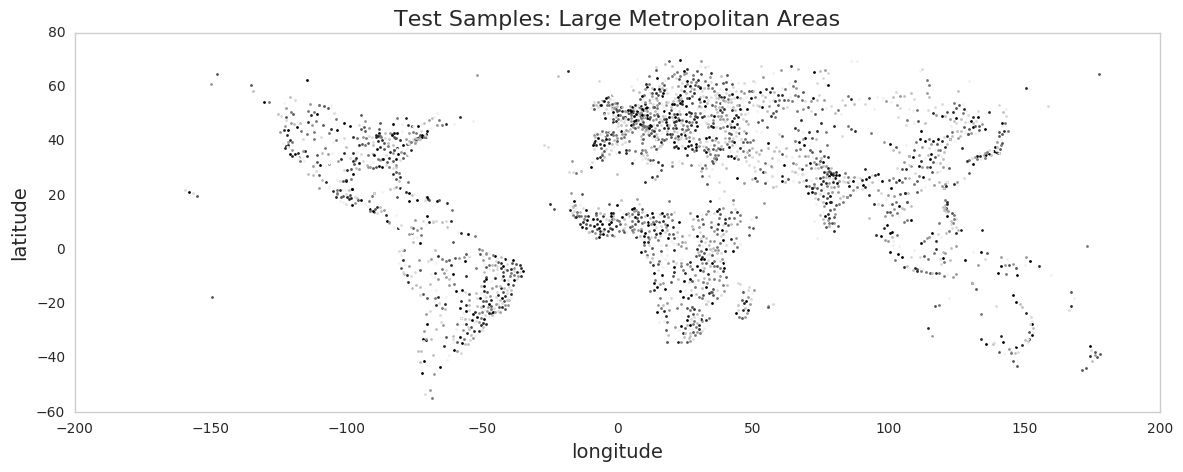

In [293]:
cities_df_sel.plot(figsize=(14,6))
plt.title("Test Samples: Large Metropolitan Areas", fontsize=16)
plt.ylabel("latitude", fontsize=14)
plt.xlabel("longitude", fontsize=14)

In [225]:
def f_classify_by_pop(d):
    if d < 50000:
        return "very-small"
    elif d < 100000:
        return "small"
    elif d < 1e6:
        return "medium"
    elif d < 2e6:
        return "large"
    elif d < 5e6:
        return "very-large"
    else:
        return "megalopolis"

cities_df['class'] = cities_df["Population"].apply(f_classify_by_pop)

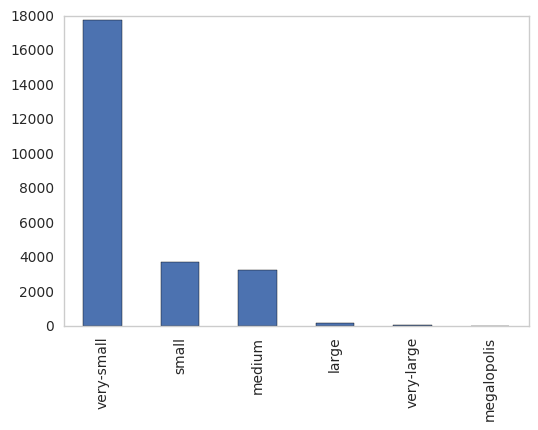

In [226]:
cities_df['class'].value_counts().plot(kind="bar")

3076


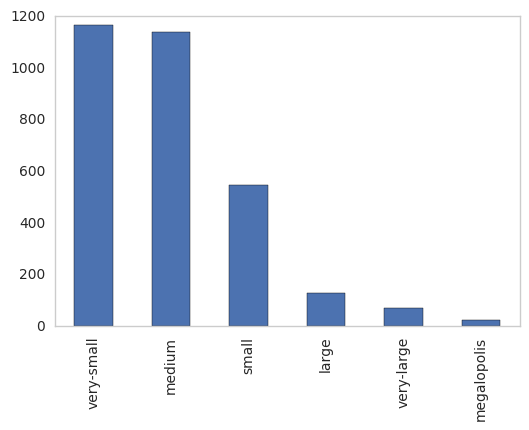

In [295]:
cities_df_sel['class'].value_counts().plot(kind="bar")
print len(cities_df_sel)

# Extract SAR samples

In [269]:
# client for SAR built geometry

sarPath = "/home/adalbert/data/GUF28/"
sarFiles = glob.glob(sarPath + "*.tif")

sarImgClient = satimg.SatImage(sarFiles)

# sarImgClient = satimg.SatImage("/home/adalbert/data/guf282.tif")



#### Plot some examples

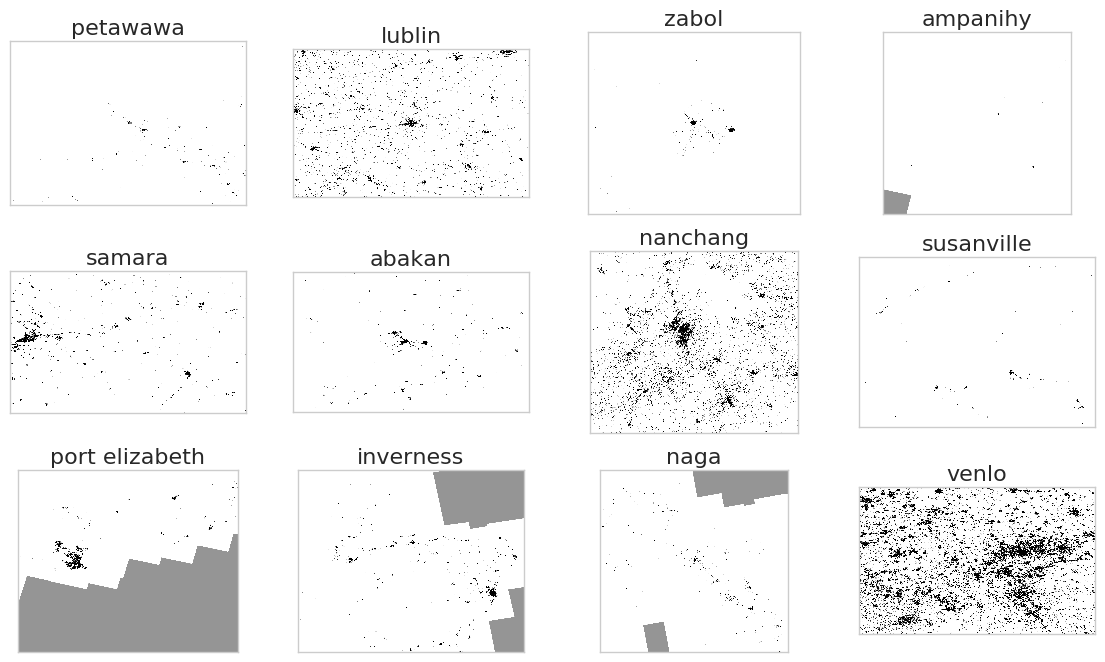

In [273]:
nrow = 3
ncol = 4

fig, ax = plt.subplots(nrow, ncol, figsize=(14,8))

smpl_df = cities_df_sel.sample(nrow*ncol).reset_index()
for i,r in smpl_df.iterrows():
    lat, lon, city, pop, country = r['Latitude'], r['Longitude'], r['City'], r['Population'], r['Country']
    # print city, lat, lon, pop, country
    img = sarImgClient.get_image_at_location((lat, lon), w=200)
    ax[i/ncol,i%ncol].imshow(img[0,:,:])
    ax[i/ncol,i%ncol].set_title(city, fontsize=16)
    
for b in ax:
    for a in b:
        a.set_xticks([])
        a.set_yticks([])

In [211]:
cities_df_sel.head()

,index,Country,City,Population,Latitude,Longitude,geometry
0,1,cn,shanghai,18653737.0,31.045556,121.399722,POINT (121.399722 31.045556)
1,2,in,bombay,18072562.0,18.975000,72.825833,POINT (72.82583299999999 18.975)
2,3,pk,karachi,11738742.0,24.905600,67.082200,POINT (67.0822 24.9056)
3,8,kr,seoul,10323448.0,37.598500,126.978300,POINT (126.9783 37.5985)
4,10,tr,istanbul,12381916.0,41.018611,28.964722,POINT (28.964722 41.018611)


#### Extract  samples: 
* training: all cities > 10k population
* test: filtered cities (by population & location)

In [291]:
kmScale = 200 # window of 200km width around center
res = 448

# # training samples
# df = cities_df
# phase = "train"

# training samples
df = cities_df_sel
phase = "test"

for i,(idx,r) in enumerate(df.iterrows()):
    imgLat, imgLon = r['Latitude'], r['Longitude']
    city, country = r['City'].replace(" ", "-"), r['Country']
    popNum, popClass = int(r['Population']), r['class'].replace(" ","-")
    
    cur_dir = outPath + "/%s/%s"%(phase, popClass)
    if not os.path.exists(cur_dir):
        os.makedirs(cur_dir)

    clear_output(wait=True)
    print "city %d/%d" % (i, len(df))

    imgSAR = sarImgClient.get_image_at_location((imgLat, imgLon), w=kmScale)
    if imgSAR is None:
        continue
    imgSAR = resize(imgSAR.squeeze(), (res,res), preserve_range=True).astype(np.uint8)

    sar_filename = "%s/SAR_%s_%s_%s_%d_%2.4f_%2.4f.png"%(cur_dir, country, city, popClass, popNum, imgLat, imgLon) 
    imsave(sar_filename, imgSAR)

    # display samples every now and then
    if i % 100 == 0:
        plt.figure(figsize=(8,4))
        plt.imshow(imgSAR)
        plt.title("SAR Image %d"%i)
        plt.show()


city 3075/3076
